In [27]:
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

In [28]:
omdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True)

In [29]:
omdb['gen_len'] = omdb.apply(lambda x: len(x.omdb_genres), axis=1)

In [30]:
omdb['gen_len'].max()

3

### The maximum number of genres for a movie is 3

In [31]:
omdb[['genre1', 'genre2', 'genre3']] = pd.DataFrame(omdb.omdb_genres.values.tolist(), index=omdb.index)

In [32]:
omdb = omdb.drop(['omdb_genres', 'gen_len'], axis=1)

In [33]:
lst = pd.concat([omdb['genre1'], omdb['genre2'], omdb['genre3']])

### Find the number of genres

In [34]:
lst.value_counts()

Drama          4676
Comedy         3134
Action         1964
Adventure      1638
Crime          1530
Romance        1527
Thriller       1190
Horror         1152
Sci-Fi          801
Fantasy         774
Documentary     757
Biography       688
Family          676
Mystery         649
Animation       546
History         387
Music           318
War             304
Musical         167
Sport           142
Western         132
Film-Noir        83
Short            68
N/A              22
News             18
Adult             4
Talk-Show         1
dtype: int64

### Drama is the genre with the highest frequency

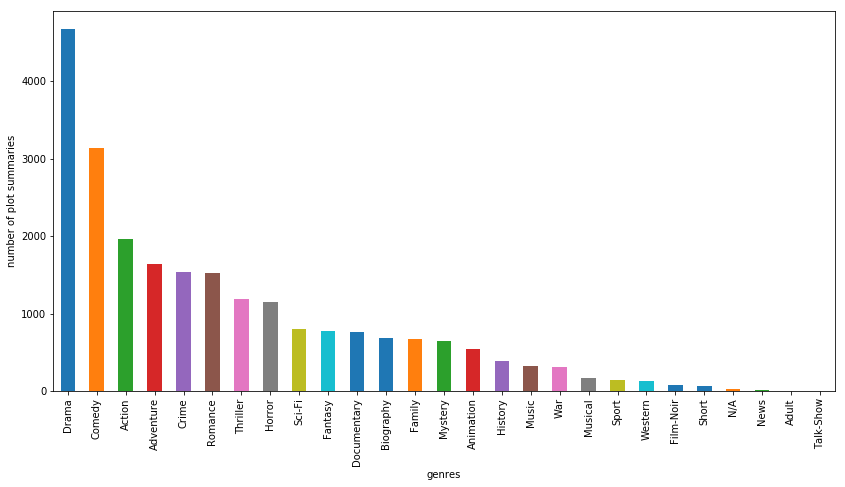

In [35]:
plt.figure(figsize=(14,7))
plt.xlabel('genres')
plt.ylabel('number of plot summaries')
lst.value_counts().plot(kind='bar')
#lst.value_counts().plot(kind='pie', autopct='%1.1f%%')

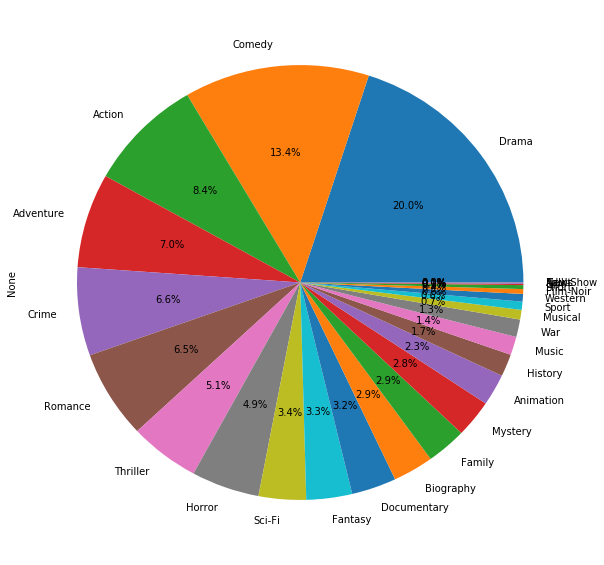

In [36]:
plt.figure(figsize=(10,10))
lst.value_counts().plot(kind='pie', autopct='%1.1f%%')

In [37]:
categories = set(list(lst)) # 27
categories

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'N/A',
 'News',
 None,
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

### Number of genres collected : 27
#### The distibution of movies towards different genres is shown in the bar chart and pie chart above. As you can see that the number of "Drama" records is way more than any other genre, hence we will use Drama as our main genre in our one-vs-all approach. Note that drama movies constitute for about 20 percent of the movies in the total set, therefore , if we just have a naive classifier which classifies all the movies as drama movies, we will still have an accuracy of 20 percent of the total genres. We have to do a lot better than that in order to produce useful trends.

In [38]:
# omdb = omdb[(omdb['genre1'] == 'Drama') | (omdb['genre2'] == 'Drama') | (omdb['genre2'] == 'Drama') | (omdb['genre1'] == 'Comedy') | (omdb['genre2'] == 'Comedy') | (omdb['genre2'] == 'Comedy')]
omdb.loc[(omdb['genre1'] == 'Drama') | (omdb['genre2'] == 'Drama') | (omdb['genre3'] == 'Drama'), "status",]='Drama'
omdb.loc[(omdb['genre1'] != 'Drama') & (omdb['genre2'] != 'Drama') & (omdb['genre3'] != 'Drama'), "status",]='Others' 

In [39]:
omdb.head()

,imdb_id,omdb_awards,omdb_plot,genre1,genre2,genre3,status
0,tt0060814,Nominated for 2 Oscars. Another 2 nominations.,"In this sprawling, star-laden film, we see the...",Drama,History,War,Drama
1,tt2379713,Won 1 Oscar. Another 7 wins & 32 nominations.,A cryptic message from the past sends James Bo...,Action,Adventure,Thriller,Others
2,tt0230575,N/A,"The makers of this parody of ""Night of the Liv...",Comedy,Horror,None,Others
3,tt0065988,Nominated for 1 Oscar. Another 5 wins & 8 nomi...,Jack Crabb is 121 years old as the film begins...,Adventure,Comedy,Drama,Drama
4,tt1995390,2 nominations.,"When Perry and his girlfriend, Gail, cross pat...",Crime,Drama,Thriller,Drama


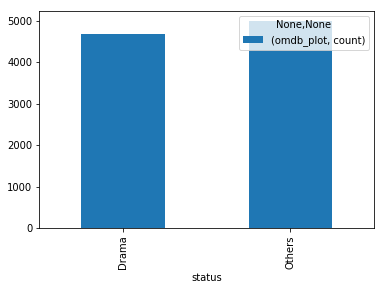

In [40]:
drama_others = omdb[['status', 'omdb_plot']].groupby(['status']).agg(['count'])
drama_others.plot(kind='bar')

In [41]:
data = omdb[['status', 'omdb_plot']]

In [42]:
data.head()

,status,omdb_plot
0,Drama,"In this sprawling, star-laden film, we see the..."
1,Others,A cryptic message from the past sends James Bo...
2,Others,"The makers of this parody of ""Night of the Liv..."
3,Drama,Jack Crabb is 121 years old as the film begins...
4,Drama,"When Perry and his girlfriend, Gail, cross pat..."


### Machine Learning with Text TF-IDF 

In [43]:
cv = TfidfVectorizer(min_df=1, stop_words='english')
X = data['omdb_plot']
y = data['status']
X_train, X_test, y_train, y_test = train_test_split(X, y)
x_traincv = cv.fit_transform(X_train)
model_1 = MultinomialNB(alpha=0.1, fit_prior=False,)
model_1.fit(x_traincv, y_train)
x_testcv = cv.transform(X_test)
predict = model_1.predict(x_testcv)
actual = np.array(y_test)
print(accuracy_score(actual, predict))

0.7126911947085572


In [44]:
my_tags = ['drama', 'others']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=0)
    plt.yticks(tick_marks, target_names)
#     plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

confusion matrix
 [[883 318]
 [377 841]]
(row=True, col=predicted)


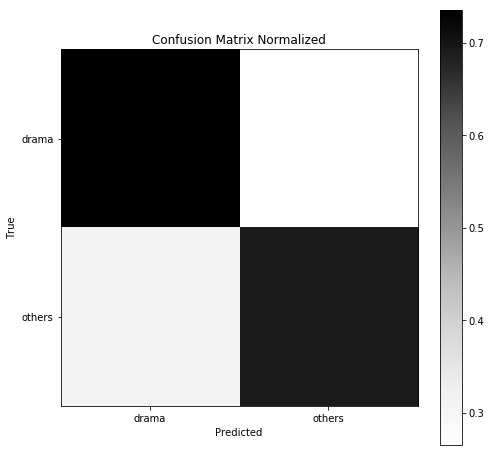

In [45]:
cm = confusion_matrix(actual, predict)
print('confusion matrix\n %s' % cm)
print('(row=True, col=predicted)')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_normalized, 'Confusion Matrix Normalized')
plt.show()

### Machine Learning with Text Count Vectorizer

In [46]:
cv1 = CountVectorizer()
X = data['omdb_plot']
y = data['status']
X_train, X_test, y_train, y_test = train_test_split(X, y)
x_traincv = cv1.fit_transform(X_train)
model_2 = MultinomialNB(alpha=0.1, fit_prior=False,)
model_2.fit(x_traincv, y_train)
x_testcv = cv1.transform(X_test)
predict2 = model_2.predict(x_testcv)
actual2 = np.array(y_test)
print(accuracy_score(actual2, predict2))

0.6969822240595287


confusion matrix
 [[835 348]
 [385 851]]
(row=True, col=predicted)


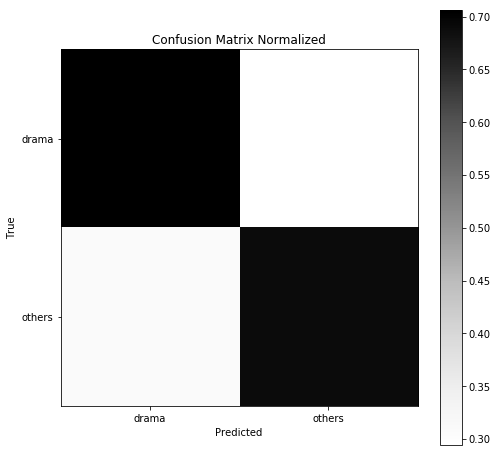

In [47]:
cm = confusion_matrix(actual2, predict2)
print('confusion matrix\n %s' % cm)
print('(row=True, col=predicted)')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_normalized, 'Confusion Matrix Normalized')
plt.show()

### Grid Searching to find the best parameters for my models

In [48]:
from sklearn.model_selection import GridSearchCV

tuning_parameters = {'alpha': [1e-2, 1e-3, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'fit_prior':[True, False]}
clf = GridSearchCV(MultinomialNB(), tuning_parameters, cv=None, n_jobs=-1, verbose=0, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split(X, y)
x_traincv = cv.fit_transform(X_train)
x_testcv = cv.transform(X_test)

clf.fit(x_traincv, y_train)
print("Best parameters set found on training set:")
print(clf.best_params_)
predicted_mb = clf.predict(x_testcv)
accuracy_score(y_test, predicted_mb)

Best parameters set found on training set:
{'alpha': 0.7, 'fit_prior': True}


0.7374948325754443

In [49]:
tuning_parameters = {'alpha': [1e-2, 1e-3, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'fit_prior':[True, False]}
clf = GridSearchCV(MultinomialNB(), tuning_parameters, cv=None, n_jobs=-1, verbose=0, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split(X, y)
x_traincv = cv1.fit_transform(X_train)
x_testcv = cv1.transform(X_test)

clf.fit(x_traincv, y_train)
print("Best parameters set found on training set:")
print(clf.best_params_)
predicted_mb = clf.predict(x_testcv)
accuracy_score(y_test, predicted_mb)

Best parameters set found on training set:
{'alpha': 1, 'fit_prior': True}


0.7329474989665151